# Uniform Generalization Bounds  for Overparametrized  Neural Networks

This notebook reproduces the experiments performed in section __6__ of the Uniform Generalization Bounds for Overparametrized Neural Networks paper. It allows to train the model to obtain $\hat{f}_n$, and calculate and plot the error rate versus the size of the training set. The notebook allows to select the dimensions of the hyper-sphere and the exponent of the Relu activation function, and therefore reproduce the results appearing in figure 2 of the paper.

In [1]:
import math
from utils import gen_rand_data_on_sphere, generate_uniform_set_on_sphere, fit_polynomial, plot_error_rate_function, create_polynomial
from utils import plot_fn
from utils import add_Gaussian_noise, get_mse, get_sup, get_mae
import numpy as np
from DenseNN import DenseNN
from DenseNN import DataAcquisitionModule
import jax.numpy as jnp
import neural_tangents as nt

import matplotlib.pyplot as plt


/home/mtkadmin/iclr_2022/opiro_env_2/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


## Visualization of Ground Truth Functions in 2D

This section gives samples of ground truth function generations. We randomly generate a specified number n of points x_i, i=1,...,n on the unit circle; generate their labels y_i = f(x_i) according to the normal distribution with covariance matrix given by the NTK at points x_i and then generate the posterior GP mean function conditioned on the specified points. We plot this posterior mean function (which is in the RKHS associated with the NTK) and its confidence intervals.   

In [2]:
NO_CONDITION_POINTS_FOR_GROUND_TRUTH = 5 #Number of given values f(x_i)=y_i 
                                         #on which we condition in order to generate the ground truth function f

/home/mtkadmin/iclr_2022/opiro_env_2/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fd2380b3410> has a label of '_nolegend_' which cannot be automatically added to the legend.
/home/mtkadmin/iclr_2022/opiro_env_2/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fd2380b3a10> has a label of '_nolegend_' which cannot be automatically added to the legend.


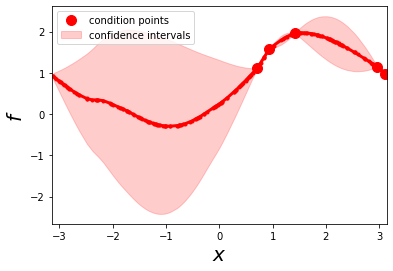

In [3]:
nn = DenseNN(1, [3])
train, samples = nn.generate_RKHS_samples(num_of_samples = 1, num_of_fixed_points = NO_CONDITION_POINTS_FOR_GROUND_TRUTH, dimension = 2, mode = 'gradient_mse_ensemble')
predict_fn =samples[0]
train_data = train[0] 
xs, ys = train_data
x_train = np.arctan2(xs[:,0], xs[:,1])

test_xs = gen_rand_data_on_sphere(200,2)    
ntk_mean, ntk_covariance = predict_fn(x_test=test_xs, get='ntk', 
                                      compute_cov=True)
xs = test_xs
test_xs = np.arctan2(xs[:,0], xs[:,1])

ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_covariance))

res = np.stack([test_xs, ntk_mean, ntk_std], axis = 1)
res = res[res[:, 0].argsort()]
test_xs = res[:,0]
ntk_mean = res[:,1]
ntk_std = res[:,2]

plot_fn((x_train,ys), (test_xs, ntk_mean))

plt.plot(test_xs, ntk_mean, 'r-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='red', alpha=0.2, label="confidence intervals")


plt.xlim([-np.pi, np.pi])
plt.legend(['condition points','_nolegend_','_nolegend_',"confidence intervals"], loc='best')


## Experiments of figure 2: Errors vs number of data points used for training.

This part of the notebook allows to reproduce the experiments outlined in figure 2b of the paper. By varying the parmeters bellow you can see error plots for different dimensions and activaction functions.

#### Parameters

In [4]:
params = {
                'NUM_OF_FIXED_POINTS_FOR_RKHS' : 100,           #No of fixed points for generating ground truth
                'DIMENSION' : 2,                                #Embedding dimension of the d-1 sphere (R^d)
                'NOISE': 0,                                     #Noise parameter for labels of ground truth
                'REG_FOR_TRAINING': 0.1,                        #Kernel regression regularization
                'NO_POINTS_SEQ' : [2**k for k in range(1,14)],  #Sequence of numbers of training points to determine error decay
                'ACTIVATION': 1                                 #Activarion: Relu^s: s=1,2,3
}

##### Network creation and Error calculation

In [5]:
nn = DenseNN(1, [3], activation = DenseNN.activation_relu(params['ACTIVATION']))

da = DataAcquisitionModule(nn, num_of_fixed_points_for_RKHS = params['NUM_OF_FIXED_POINTS_FOR_RKHS'], dimension = params['DIMENSION'], 
                                reg_target_fn = params['REG_FOR_TRAINING'], normalize_target_fn = True, norm_range = True)
errors = da.train_with_random_data(no_data_points_list = params['NO_POINTS_SEQ'], 
                                                noise_level = params['NOISE'], diag_reg_for_training = params['REG_FOR_TRAINING'],
                                                num_of_samples_for_error_calculation = 10000)
errors = np.squeeze(np.array(errors))
errors = get_sup(errors)

#### Plot

/home/mtkadmin/iclr_2022/utils.py:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt_obj.plot(x, y, 'ro', markersize=5, label='train', color = color)
/home/mtkadmin/iclr_2022/opiro_env_2/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


Text(0.5, 0.9, 'Slope: -0.5177129018638746 \n Intercept: -0.05866902149640607')

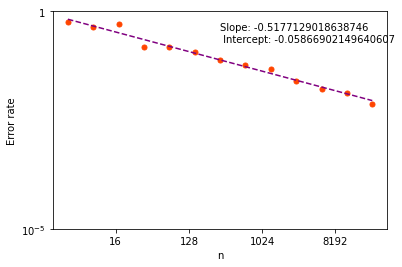

In [6]:
xs = params['NO_POINTS_SEQ'] 
xs,ys,slope,intercept, stderr =  fit_polynomial(xs, errors)
func = lambda x : slope * x + intercept

ax = plt.gca()
pl = plot_error_rate_function(func, xs, ys, plt_obj = ax, color = 'orangered')
pl.set_xticklabels(np.power(2,range(1,14,3)))

max_y = max(ys)
min_y = min(ys)
ax.set_yticks([np.log(10**(-5)), 0])
pl.set_ylim(np.log(10**(-5)),0)
label = [r'$10^{-5}$',r'$1$']
ax.set_yticklabels(label)
ax.set_xlabel('n')
ax.set_ylabel('Error rate')
pl.text(0.5, 0.9, 'Slope: {} \n Intercept: {}'.format(slope,intercept), horizontalalignment = 'left', 
                        verticalalignment='center', transform=ax.transAxes)
